>> # Modelo preditivo -  EDP
- Modelagem preditiva para devedor mais propenso a pagar
- Este Jupyter contém as etapas de ETL e Modelagem
- G:\Drives compartilhados\Inteligência de Negócios 2\BORDEROS\BORDEROS 2022\EDP

# Importando pacotes e bibliotecas

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import os , gc, time, urllib, pyodbc, warnings
warnings.filterwarnings("ignore")
from datetime import date, timedelta
import sqlalchemy as sql
from sqlalchemy import create_engine
from ayx import Alteryx

ModuleNotFoundError: No module named 'ayx'

# ETL


In [2]:
params = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=10.10.220.100;"
                                 "DATABASE=dbActyon_Enel;" # trocar o nome da operação
                                 "UID=ralisson.local;"
                                 "PWD=A4TIL&fRplPn;"
                                 "Trusted_Connection=no")
engine = sql.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params))
engine.connect

<bound method Engine.connect of Engine(mssql+pyodbc:///?odbc_connect=DRIVER%3D%7BSQL+Server+Native+Client+11.0%7D%3BSERVER%3D10.10.220.100%3BDATABASE%3DdbActyon_Enel%3BUID%3Dralisson.local%3BPWD%3DA4TIL%26fRplPn%3BTrusted_Connection%3Dno)>

In [3]:
#Criando variavei de datas para coleta da query sql

TODAY = date.today()
YESTERDAY = date.today() - timedelta(days=90)
data_inicio = f"{YESTERDAY.year}-{YESTERDAY.month}-{YESTERDAY.day}" #yesterday 
data_final = f"{TODAY.year}-{TODAY.month}-{TODAY.day}"

In [4]:
#Importando dados do banco de dados SQL

query = '''

    SELECT DISTINCT

        tbdevedor.DEVEDOR_ID,
        tbdevedor.CEP,
        tbdevedor_fone.FONE,
        tbdevedor_fone.TIPO,
        tbdevedor_fone.STATUS,
        tbdevedor_fone.ORIGEM,
        tbdevedor.QTDE_TITULOS,
        tbdevedor.VALOR_DIVIDA_ATIVA,
        tbdevedor.CONT_ID,
        tbdevedor_acionamento.ACAO_ID,
        tbacao_cobranca.DESCRICAO


    FROM tbdevedor
        JOIN tbdevedor_acionamento WITH(NOLOCK) ON tbdevedor_acionamento.DEVEDOR_ID = tbdevedor.DEVEDOR_ID
        JOIN tbacao_cobranca WITH(NOLOCK) ON tbacao_cobranca.ACAO_ID = tbdevedor_acionamento.ACAO_ID
        JOIN tbdevedor_fone WITH(NOLOCK) ON tbdevedor.DEVEDOR_ID = tbdevedor_fone.DEVEDOR_ID
        JOIN tbcontratante WITH(NOLOCK) ON tbdevedor.CONT_ID = tbcontratante.CONTRATANTE_ID

    WHERE tbcontratante.CONTRATANTE_ID IN ('91', '93', '95', '106', '107', '110', '114','115','116','118','127', '128', '130', '131',
                                           '144','168','169', '170', '171', '175', '176', '188', '189' )
    AND tbdevedor_acionamento.DATA between 

'''
#df = pd.read_sql(query, engine)
df = pd.read_sql(query + f"'{data_inicio}' AND '{data_final}'", engine)
print("tamanho da tabela: ", df.shape)

engine.dispose()
gc.collect()

tamanho da tabela:  (3797199, 11)


0

In [5]:
df = df.drop_duplicates()
df.dropna(inplace=True)
#df.dropna(inplace = True)
df.shape

(3337269, 11)

# Engenharia de Atributos

In [6]:
#alterando tipo das featrures
df['CEP'] = df['CEP'].astype('category')
df['CONT_ID'] = df['CONT_ID'].astype('category')
df['TIPO'] = df['TIPO'].astype('category')
df['STATUS'] = df['STATUS'].astype('category')
df['ORIGEM'] = df['ORIGEM'].astype('category')
df['ACAO_ID'] = df['ACAO_ID'].astype('category')
df['FONE'] = df['FONE'].astype(str)

In [7]:
acionamento = df.groupby(['ACAO_ID', 'DESCRICAO'])['FONE'].count().reset_index()

In [ ]:
acionamento.to_csv('acionamento.csv', sep=';' ,index=False, encoding='latin1')

##### importando De Para de Acionamentos

In [8]:
# Importando acionamento tratado
depara = pd.read_csv('acionamento.csv', sep=';' , encoding='latin1')
depara.drop_duplicates(inplace=True)

In [12]:
depara.TARGET.value_counts()

0    23
1    20
Name: TARGET, dtype: int64

In [10]:
df2 = pd.merge(df, depara, how='left', on='DESCRICAO')

In [11]:
df2['TARGET'] = df2['TARGET'].fillna(0)

In [13]:
df2.sample(10)

,DEVEDOR_ID,CEP,FONE,TIPO,STATUS,ORIGEM,QTDE_TITULOS,VALOR_DIVIDA_ATIVA,CONT_ID,ACAO_ID,DESCRICAO,TARGET
1896260,34789635,,85998176890,C,0,Importação,1.0,284.52,168,7872,MENSAGEM ENTREGUE (SMS),1.0
2964699,38269618,62265000,8836391674,R,0,Importação,5.0,423.71,176,7429,NÃO ATENDE,0.0
849817,13864878,,88994679720,C,0,Higienização,1.0,124.55,115,1972,NAO CONSTA NA LISTA TELEFONICA,0.0
3539470,40793121,,85991758173,C,0,Importação,1.0,303.21,168,7872,MENSAGEM ENTREGUE (SMS),1.0
3282595,39732346,62590000,85985352947,C,1,Importação,3.0,258.82,175,5747,NÃO IDENTIFICADO,0.0
1200108,32315092,,85999202580,C,0,Importação,1.0,73.56,168,7871,MENSAGEM NÃO ENTREGUE (SMS),0.0
44037,1536640,,85991606705,C,0,Importação,2.0,1123.54,91,18,NÃO ATENDE,0.0
447002,12520532,62840000,85992193259,C,0,Higienização,1.0,685.45,114,1883,CONTATO SEM AGENDAMENTO,0.0
1464063,33179218,,85985285154,C,0,Importação,1.0,87.91,168,7872,MENSAGEM ENTREGUE (SMS),1.0
189740,11706936,,85999219560,O,0,Higienização,1.0,618.03,114,1842,AGENDADO,1.0


In [14]:
df = df2

<AxesSubplot:>

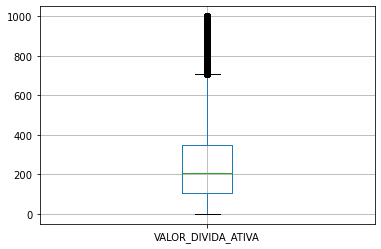

In [19]:
df.sample(frac=0.1).boxplot('VALOR_DIVIDA_ATIVA')

<AxesSubplot:>

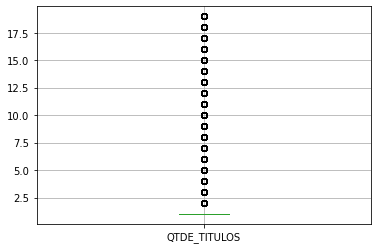

In [20]:
df.sample(frac=0.1).boxplot('QTDE_TITULOS')

In [18]:
df = df.query('VALOR_DIVIDA_ATIVA < 1000')
df = df.query('QTDE_TITULOS < 20 ')
df.shape

(3292515, 12)

In [21]:
df.isna().sum()

DEVEDOR_ID            0
CEP                   0
FONE                  0
TIPO                  0
STATUS                0
ORIGEM                0
QTDE_TITULOS          0
VALOR_DIVIDA_ATIVA    0
CONT_ID               0
ACAO_ID               0
DESCRICAO             0
TARGET                0
dtype: int64

# Pre Processamento dos dados

## Balanceamento de Variáveis

In [22]:
df.TARGET.value_counts()

0.0    1678651
1.0    1613864
Name: TARGET, dtype: int64

Class 0: 1678651
Class 1: 1613864
Proportion: 1.04 : 1


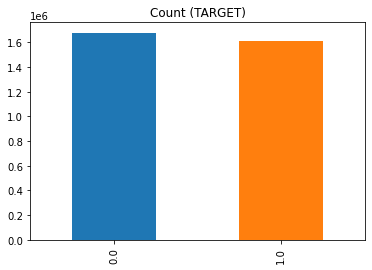

In [23]:
target_count = df['TARGET'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
target_count.plot(kind='bar', title='Count (TARGET)',color = ['#1F77B4', '#FF7F0E']);

Random under-sampling:
0.0    1613864
1.0    1613864
Name: TARGET, dtype: int64


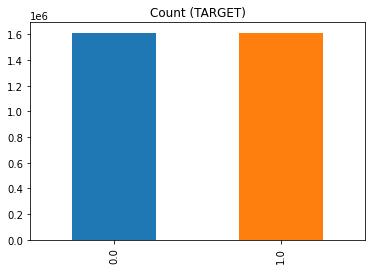

In [24]:
# CONTAR CLASSES
count_class_0, count_class_1 = df['TARGET'].value_counts()
# Divide by class
df_class_0 = df[df['TARGET'] == 0]
df_class_1 = df[df['TARGET'] == 1]
df_class_0_under = df_class_0.sample(count_class_1)
df = pd.concat([df_class_0_under, df_class_1], axis=0)
print('Random under-sampling:')
print(df['TARGET'].value_counts())
df['TARGET'].value_counts().plot(kind='bar', title='Count (TARGET)',color = ['#1F77B4', '#FF7F0E']);

In [25]:
df.TARGET.value_counts()

0.0    1613864
1.0    1613864
Name: TARGET, dtype: int64

In [33]:
features = df[[ 'QTDE_TITULOS', 'VALOR_DIVIDA_ATIVA', 'CEP', 'CONT_ID', 'TIPO' , 'ORIGEM']] #STATUS
target = df[['TARGET']]

## Padronização ou Normalização das variáveis

In [34]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
features['CONT_ID']= le.fit_transform(features["CONT_ID"])
features['CEP']= le.fit_transform(features["CEP"])
features['TIPO']= le.fit_transform(features["TIPO"])
#features['STATUS']= le.fit_transform(features["STATUS"])
features['ORIGEM']= le.fit_transform(features["ORIGEM"])


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features['QTDE_TITULOS'] = scaler.fit_transform(features[['QTDE_TITULOS']])
features['VALOR_DIVIDA_ATIVA'] = scaler.fit_transform(features[['VALOR_DIVIDA_ATIVA']])


# Modelagem preditiva

In [35]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [36]:
# Separando as features e target
X = features
Y = target

# Divide os dados em treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 5)

# Criando o modelo
#Model = RandomForestClassifier(n_estimators=100)
#Model = GradientBoostingClassifier(n_estimators=150,  learning_rate=0.1)
#Model = MLPClassifier(hidden_layer_sizes=(50,50,50), alpha=0.01 )
Model = XGBClassifier(nthread = 48, objective = 'binary:logistic',  max_depth = 12, n_estimators=100) 

# Definindo os valores para o número de folds
num_folds = 3
seed = 7
    
# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)    

# Treinando o modelo
Model.fit(X_train, Y_train)

# Previsão do modelo
Predict = Model.predict(X_test)

# Acurácia final e ROC
resultadoAC = cross_val_score(Model, X, Y, cv = kfold, scoring = 'accuracy')
#resultadoROC = cross_val_score(Model, X, Y, cv = kfold, scoring = 'roc_auc')

print("A Acurácia foi de: %.3f%%" % (resultadoAC.mean() * 100.0))
#print("ROC foi de: %.3f" % (resultadoROC.mean() * 100))

report = classification_report(Y_test, Predict)

# Imprimindo o relatório
print(report)

[21:54:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:57:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:00:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:04:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [37]:
print(report)

              precision    recall  f1-score   support

         0.0       0.65      0.51      0.57    532173
         1.0       0.60      0.73      0.65    532978

    accuracy                           0.62   1065151
   macro avg       0.62      0.62      0.61   1065151
weighted avg       0.62      0.62      0.61   1065151



## Análise de Features e Acurácia

In [38]:
# Seleção dos melhores atributos como resultado para a modelagem CPC
gc.collect()
Model.feature_importances_
feature_importances = pd.DataFrame(Model.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances



,importance
CEP,0.383051
CONT_ID,0.250332
ORIGEM,0.112101
VALOR_DIVIDA_ATIVA,0.102481
TIPO,0.076827
QTDE_TITULOS,0.075208


In [39]:
# Salvando o modelo Propensao a pagar
import pickle

arquivo_cpf = 'modelo_v1.sav'
pickle.dump(Model, open(arquivo_cpf, 'wb'))
print("Modelo salvo!")

# Salvar as features do modelo
with open('NameFeature_v1','wb') as arquivo_cpf:
   pickle.dump(features.columns, arquivo_cpf)

print('Nomes Salvo')

Modelo salvo!
Nomes Salvo
